# occupancy prediction

![img](dev/IMG_6435.jpg)

plan:
- split `real_data_array` into `timeunit` chunks
- compute transition matrix for each chunk
- simulate `timeunit` length of data using each transition matrix
- compare simulated data to each respective real data chunk
- make sure to normalize the *`timestep`* with `scipy.signal.decimate`
<br>
<br>

In [50]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from tqdm import tqdm_notebook, tnrange, trange, tqdm
from itertools import cycle
from collections import Counter
from pathlib import Path
import time

import altair as alt
from altair.expr import datum
alt.data_transformers.enable('json')

from _modules.wifi_traffic_analyzer import WifiTrafficAnalyzer

## params

In [2]:
timestep = 250
timeunit = 10_000

## configs

In [3]:
real_data_path_dict = {
    'real_2': Path(r'data/wifitrafficstats2.csv'),
    'real_3': Path(r'data/wifitrafficstats3.csv'),
    'real_4': Path(r'data/wifitrafficstats4.csv'),
    'real_5': Path(r'data/wifitrafficstats5.csv'),
    'real_6': Path(r'data/wifitrafficstats6.csv')
}

transition_matrices_path_dict = {
    'tmat_1': Path(r'data/wifi_t_matrices.csv'),
    #'tmat_2': Path(r'data/wifi_t_matrices2.csv')
}

## occupancy predictor

### classing it up

In [36]:
class OccupancyPredictor:
    def __init__(self, real_data_path_dict, timeunits, timestep, autoselect_file=True):
        print('initializing OP..')
        
        # attributes
        self.real_data_path_dict = real_data_path_dict
        self.timestep = timestep
        
        # set timeunits
        if not isinstance(timeunits, list):
            self.timeunits = [timeunits]
            print(f'single timeunit received {self.timeunits}')
        else:
            self.timeunits = timeunits
            print(f'{len(self.timeunits)} timeunits received')            
        
        # startup tasks
        self.WTA_real = WifiTrafficAnalyzer(mode='real', path_dict=self.real_data_path_dict)
        self.select_file_key(autoselect=autoselect_file)
        
        
    
    def select_file_key(self, autoselect):        
        if autoselect:
            self.file_key = list(self.WTA_real.path_dict.keys())[1]
            self.WTA_real.process_real_data(self.file_key)
            print(f'\tautoselected and processed \'{self.file_key}\'')
            
        else:
            file_key = input('please select a target file..')
            
            try:
                assert file_key.strip().lower() in self.WTA_real.path_dict.keys()
                
                self.file_key = file_key.strip().lower()
                self.WTA_real.process_real_data(self.file_key)
                
                print(f'\tset and processed target file: {self.file_key}')
                
            except AssertionError:
                print(f'invalid target file: {file_key}, options are {self.WTA_real.path_dict.keys()}')
                raise
        
        
    def convert_and_reshape(self, timeunit, downsample_factor):
        self.data_array = self.decimate_signal(
            self.WTA_real.real_data_array,
            downsample_factor
        )
        print(f'generated real data array, size: {self.data_array.shape}')
        
        data_matrix = (
            self.data_array[
                :int(timeunit*np.floor(len(self.data_array) / timeunit))
            ].reshape((-1, timeunit))
        )
        print(f'reshaped into {data_matrix.shape[0]} : {timeunit}µs chunks')
        
        return data_matrix
    
    
    def decimate_signal(self, data_array, factor):
        return signal.decimate(
            data_array,
            factor,
            ftype='fir'
        )
    
        
    def compute_transition_matrix(self, row, timeunit):
        onon, onoff, offon, offoff = 0, 0, 0, 0
        
        for i in range(timeunit-1):    
            # if ON -> ON
            if row[i] == row[i+1] == 1:
                onon += 1
                
            # if ON -> OFF
            elif row[i] == 1 and row[i+1] == 0:
                onoff += 1
                
            # if OFF -> ON
            elif row[i] == 0 and row[i+1] == 1:
                offon += 1
                
            #if OFF -> OFF
            elif row[i] == row[i+1] == 0:
                offoff += 1
                
        try:
            p_onon = onon / (onon + onoff)
        except ZeroDivisionError:
            p_onon = 0
        
        try:
            p_offoff = offoff / (offoff + offon)
        except ZeroDivisionError:
            p_offoff = 0
            
        try:
            p_onoff = onoff / (onon + onoff)
        except ZeroDivisionError:
            p_onoff = 0
            
        try:
            p_offon = offon / (offoff + offon)
        except ZeroDivisionError:
            p_offon = 0
            
        
        return (p_onon, p_onoff, p_offon, p_offoff) 
    
    
    def compute_tmats_and_load_df(self, data_matrix, timeunit):
        # compute all transition matrices
        tmat_array = [
            self.compute_transition_matrix(
                data_matrix[idx,:],
                timeunit
            )
            for idx in tnrange(data_matrix.shape[0])
        ]
        
        # load dataframe
        tmat_df = (
            pd
            .DataFrame(
                tmat_array, 
                columns=['OnOn', 'OnOff', 'OffOn', 'OffOff']
            ).assign(
                timeunit = timeunit,
                source = self.file_key
            )
            [['OnOn','OnOff','OffOff','OffOn','timeunit','source']]
        )
        print(f'created transition matrix dataframe, {tmat_df.shape[0]} rows')
        
        return tmat_df
    
    
    def process_timeunit(self, timeunit):
        print(f'processing data for timeunit: {timeunit}µs')
        
        data_matrix = self.convert_and_reshape(timeunit, self.timestep)        
        tmat_df = self.compute_tmats_and_load_df(data_matrix, timeunit)
        
        return data_matrix, tmat_df
        
        

In [39]:


def iterate_params(tstep, timeunit):
    OP = OccupancyPredictor(real_data_path_dict, timeunit, tstep, autoselect_file=True)
    
    data_matrix, tmat_df = OP.process_timeunit(int(OP.timeunits[0]/tstep))
    
    print(f'data matrix: {data_matrix.shape}')
    
    sim_data_matrix = OP.WTA_real.simulate_all_OP_transition_matrices(
        tmat_dataframe=tmat_df,
        n_samples=int(OP.timeunits[0]/tstep), 
        m_trials=1
    )[1:,:]
    
    print(f'sim data matrix: {sim_data_matrix.shape}')
    
    comp_df = (
        pd
        .DataFrame({
            'real_data': data_matrix.sum(axis=1),
            'sim_data': sim_data_matrix.sum(axis=1)
        })
        .assign(
            real_data = lambda x: x.real_data.astype('int'),
            sim_data = lambda x: x.sim_data.astype('int'),
            timestep = tstep,
            timeunit = timeunit
        )
        .eval('diff = sim_data - real_data')
    )
    
    return comp_df
    
    

In [40]:
df_dict = {}
timesteps = list(range(50, 2000, 50))
timeunit = 10_000

for tstep in timesteps:
    df_dict[tstep] = iterate_params(tstep, timeunit)

initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 200µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (1437699,)
reshaped into 7188 : 200µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 200)



total elapsed time: 0.06 minutes
sim data matrix: (7188, 200)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 100µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (718850,)
reshaped into 7188 : 100µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 100)



total elapsed time: 0.03 minutes
sim data matrix: (7188, 100)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 66µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (479233,)
reshaped into 7261 : 66µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 66)



total elapsed time: 0.02 minutes
sim data matrix: (7261, 66)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 50µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (359425,)
reshaped into 7188 : 50µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 50)



total elapsed time: 0.02 minutes
sim data matrix: (7188, 50)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 40µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (287540,)
reshaped into 7188 : 40µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 40)



total elapsed time: 0.01 minutes
sim data matrix: (7188, 40)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 33µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (239617,)
reshaped into 7261 : 33µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 33)



total elapsed time: 0.01 minutes
sim data matrix: (7261, 33)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 28µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (205386,)
reshaped into 7335 : 28µs chunks



created transition matrix dataframe, 7335 rows
data matrix: (7335, 28)



total elapsed time: 0.01 minutes
sim data matrix: (7335, 28)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 25µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (179713,)
reshaped into 7188 : 25µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 25)



total elapsed time: 0.01 minutes
sim data matrix: (7188, 25)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 22µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (159745,)
reshaped into 7261 : 22µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 22)



total elapsed time: 0.01 minutes
sim data matrix: (7261, 22)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 20µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (143770,)
reshaped into 7188 : 20µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 20)



total elapsed time: 0.01 minutes
sim data matrix: (7188, 20)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 18µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (130700,)
reshaped into 7261 : 18µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 18)



total elapsed time: 0.01 minutes
sim data matrix: (7261, 18)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 16µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (119809,)
reshaped into 7488 : 16µs chunks



created transition matrix dataframe, 7488 rows
data matrix: (7488, 16)



total elapsed time: 0.01 minutes
sim data matrix: (7488, 16)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 15µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (110593,)
reshaped into 7372 : 15µs chunks



created transition matrix dataframe, 7372 rows
data matrix: (7372, 15)



total elapsed time: 0.01 minutes
sim data matrix: (7372, 15)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 14µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (102693,)
reshaped into 7335 : 14µs chunks



created transition matrix dataframe, 7335 rows
data matrix: (7335, 14)



total elapsed time: 0.01 minutes
sim data matrix: (7335, 14)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 13µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (95847,)
reshaped into 7372 : 13µs chunks



created transition matrix dataframe, 7372 rows
data matrix: (7372, 13)



total elapsed time: 0.01 minutes
sim data matrix: (7372, 13)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 12µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (89857,)
reshaped into 7488 : 12µs chunks



created transition matrix dataframe, 7488 rows
data matrix: (7488, 12)



total elapsed time: 0.01 minutes
sim data matrix: (7488, 12)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 11µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (84571,)
reshaped into 7688 : 11µs chunks



created transition matrix dataframe, 7688 rows
data matrix: (7688, 11)



total elapsed time: 0.01 minutes
sim data matrix: (7688, 11)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 11µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (79873,)
reshaped into 7261 : 11µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 11)



total elapsed time: 0.01 minutes
sim data matrix: (7261, 11)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 10µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (75669,)
reshaped into 7566 : 10µs chunks



created transition matrix dataframe, 7566 rows
data matrix: (7566, 10)



total elapsed time: 0.01 minutes
sim data matrix: (7566, 10)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 10µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (71885,)
reshaped into 7188 : 10µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 10)



total elapsed time: 0.01 minutes
sim data matrix: (7188, 10)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 9µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (68462,)
reshaped into 7606 : 9µs chunks



created transition matrix dataframe, 7606 rows
data matrix: (7606, 9)



total elapsed time: 0.01 minutes
sim data matrix: (7606, 9)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 9µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (65350,)
reshaped into 7261 : 9µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 9)



total elapsed time: 0.01 minutes
sim data matrix: (7261, 9)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 8µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (62509,)
reshaped into 7813 : 8µs chunks



created transition matrix dataframe, 7813 rows
data matrix: (7813, 8)



total elapsed time: 0.01 minutes
sim data matrix: (7813, 8)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 8µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (59905,)
reshaped into 7488 : 8µs chunks



created transition matrix dataframe, 7488 rows
data matrix: (7488, 8)



total elapsed time: 0.00 minutes
sim data matrix: (7488, 8)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 8µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (57508,)
reshaped into 7188 : 8µs chunks



created transition matrix dataframe, 7188 rows
data matrix: (7188, 8)



total elapsed time: 0.00 minutes
sim data matrix: (7188, 8)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 7µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (55297,)
reshaped into 7899 : 7µs chunks



created transition matrix dataframe, 7899 rows
data matrix: (7899, 7)



total elapsed time: 0.00 minutes
sim data matrix: (7899, 7)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 7µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (53249,)
reshaped into 7607 : 7µs chunks



created transition matrix dataframe, 7607 rows
data matrix: (7607, 7)



total elapsed time: 0.00 minutes
sim data matrix: (7607, 7)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 7µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (51347,)
reshaped into 7335 : 7µs chunks



created transition matrix dataframe, 7335 rows
data matrix: (7335, 7)



total elapsed time: 0.00 minutes
sim data matrix: (7335, 7)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 6µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (49576,)
reshaped into 8262 : 6µs chunks



created transition matrix dataframe, 8262 rows
data matrix: (8262, 6)



total elapsed time: 0.00 minutes
sim data matrix: (8262, 6)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 6µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (47924,)
reshaped into 7987 : 6µs chunks



created transition matrix dataframe, 7987 rows
data matrix: (7987, 6)



total elapsed time: 0.00 minutes
sim data matrix: (7987, 6)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 6µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (46378,)
reshaped into 7729 : 6µs chunks



created transition matrix dataframe, 7729 rows
data matrix: (7729, 6)



total elapsed time: 0.00 minutes
sim data matrix: (7729, 6)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 6µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (44929,)
reshaped into 7488 : 6µs chunks



created transition matrix dataframe, 7488 rows
data matrix: (7488, 6)



total elapsed time: 0.00 minutes
sim data matrix: (7488, 6)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 6µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (43567,)
reshaped into 7261 : 6µs chunks



created transition matrix dataframe, 7261 rows
data matrix: (7261, 6)



total elapsed time: 0.00 minutes
sim data matrix: (7261, 6)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 5µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (42286,)
reshaped into 8457 : 5µs chunks



created transition matrix dataframe, 8457 rows
data matrix: (8457, 5)



total elapsed time: 0.01 minutes
sim data matrix: (8457, 5)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 5µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (41078,)
reshaped into 8215 : 5µs chunks



created transition matrix dataframe, 8215 rows
data matrix: (8215, 5)



total elapsed time: 0.01 minutes
sim data matrix: (8215, 5)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 5µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (39937,)
reshaped into 7987 : 5µs chunks



created transition matrix dataframe, 7987 rows
data matrix: (7987, 5)



total elapsed time: 0.00 minutes
sim data matrix: (7987, 5)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 5µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (38857,)
reshaped into 7771 : 5µs chunks



created transition matrix dataframe, 7771 rows
data matrix: (7771, 5)



total elapsed time: 0.00 minutes
sim data matrix: (7771, 5)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 5µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (37835,)
reshaped into 7567 : 5µs chunks



created transition matrix dataframe, 7567 rows
data matrix: (7567, 5)



total elapsed time: 0.00 minutes
sim data matrix: (7567, 5)
initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv



	autoselected and processed 'real_3'
processing data for timeunit: 5µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (36865,)
reshaped into 7373 : 5µs chunks



created transition matrix dataframe, 7373 rows
data matrix: (7373, 5)



total elapsed time: 0.00 minutes
sim data matrix: (7373, 5)


In [42]:
len(df_dict.keys())

39

In [44]:
full_comp_df = pd.concat([df for df in df_dict.values()])

In [68]:
(full_comp_df
 .eval('real_data = real_data * timestep / timeunit')
 .eval('sim_data = sim_data * timestep / timeunit')
 .assign(pct_diff = lambda x: np.abs(x.sim_data - x.real_data))
 .head()
)

,real_data,sim_data,timestep,timeunit,diff,pct_diff
0,0.270,0.000,50,10000,-54,0.270
1,0.350,0.015,50,10000,-67,0.335
2,0.285,0.000,50,10000,-57,0.285
3,0.090,0.010,50,10000,-16,0.080
4,0.265,0.000,50,10000,-53,0.265


In [45]:
full_comp_df.head()

,real_data,sim_data,timestep,timeunit,diff
0,54,0,50,10000,-54
1,70,3,50,10000,-67
2,57,0,50,10000,-57
3,18,2,50,10000,-16
4,53,0,50,10000,-53


In [55]:
full_comp_df.groupby('timestep').diff.mean()

timestep
50     -46.322621
100    -22.690874
150    -14.644815
200    -10.913745
250     -8.547718
300     -6.844099
350     -5.681800
400     -4.970924
450     -4.295689
500     -3.785615
550     -3.358215
600     -2.865919
650     -2.642295
700     -2.419359
750     -2.189365
800     -1.936031
850     -1.718652
900     -1.694532
950     -1.501983
1000    -1.467307
1050    -1.271759
1100    -1.238259
1150    -1.002432
1200    -0.985978
1250    -0.965776
1300    -0.759210
1350    -0.770606
1400    -0.765372
1450    -0.549262
1500    -0.537749
1550    -0.548454
1600    -0.525107
1650    -0.546343
1700    -0.339600
1750    -0.321120
1800    -0.342557
1850    -0.306267
1900    -0.345183
1950    -0.322528
Name: diff, dtype: float64

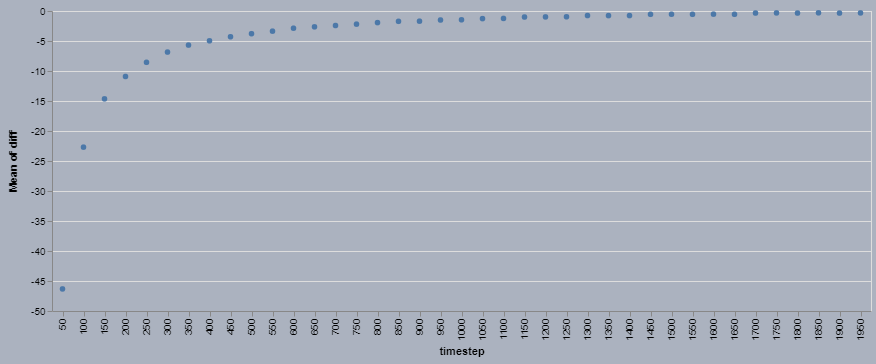

In [49]:
alt.Chart(
    full_comp_df
).mark_circle(
).encode(
    alt.X('timestep:N'),
    alt.Y('mean(diff):Q')
).configure(
    background='#abb2bf'
)

In [5]:
OP = OccupancyPredictor(real_data_path_dict, timeunit, autoselect_file=False)

initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv


please select a target file.. real_3



	set and processed target file: real_3


In [6]:
data_matrix, tmat_df = OP.process_timeunit(int(OP.timeunits[0]/timestep))

print(f'data matrix: {data_matrix.shape}')
display(tmat_df.head())

processing data for timeunit: 40µs


C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\je023d\AppData\Local\Continuum\anaconda3\envs\py36-uwhw\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


generated real data array, size: (143770,)
reshaped into 3594 : 40µs chunks



created transition matrix dataframe, 3594 rows
data matrix: (3594, 40)


,OnOn,OnOff,OffOff,OffOn,timeunit,source
0,0,0,0.0,0.0,40,real_3
1,0,0,0.0,0.0,40,real_3
2,0,0,0.0,0.0,40,real_3
3,0,0,1.0,0.0,40,real_3
4,0,0,1.0,0.0,40,real_3


In [7]:
sim_data_matrix = OP.WTA_real.simulate_all_OP_transition_matrices(
    tmat_dataframe=tmat_df,
    n_samples=int(OP.timeunits[0]/timestep), 
    m_trials=1
)[1:,:]

print(f'sim data matrix: {sim_data_matrix.shape}')


total elapsed time: 0.01 minutes
sim data matrix: (3594, 40)


In [8]:
print(f'real data shape: {data_matrix.shape}')
data_matrix.sum(axis=1)[:10]

real data shape: (3594, 40)


array([ 1.21570052e+01,  8.02332010e+00,  1.16137669e+01,  5.37242490e-01,
        0.00000000e+00, -3.67512026e-04,  7.60159118e+00,  1.15153797e+01,
        2.19880577e+00,  7.39377829e+00])

In [9]:
print(f'sim data shape: {sim_data_matrix.shape}')
sim_data_matrix.sum(axis=1)[:10]

sim data shape: (3594, 40)


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [10]:
comp_df = (
    pd
    .DataFrame({
        'real_data': data_matrix.sum(axis=1),
        'sim_data': sim_data_matrix.sum(axis=1)
    })
    .assign(
        real_data = lambda x: x.real_data.astype('int'),
        sim_data = lambda x: x.sim_data.astype('int')
    )
    .eval('diff = sim_data - real_data')
)

comp_df.head()

,real_data,sim_data,diff
0,12,0,-12
1,8,0,-8
2,11,0,-11
3,0,0,0
4,0,0,0


In [11]:
comp_df.shape

(3594, 3)

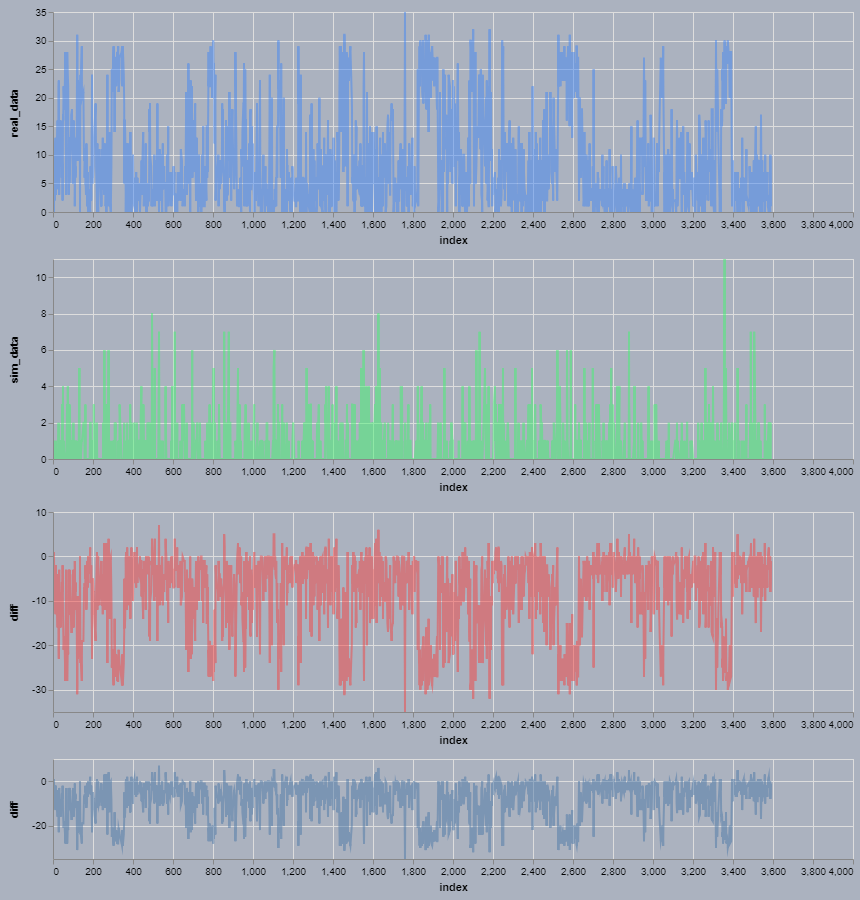

In [12]:
x_scaler = alt.selection_interval(encodings=['x'])

base = alt.Chart(
    comp_df.reset_index().sample(frac=0.5),
    height=200,
    width=800
#).transform_filter(
#    x_scaler
).mark_line(
    opacity=0.5
).encode(
    alt.X('index:Q', scale={'domain': x_scaler.ref()}),
    #alt.Y('real_data:Q')
)

layered = alt.vconcat(
    base.encode(
        alt.Y('real_data:Q'),
        color=alt.value('#4286f4') # blue
    ).transform_filter(x_scaler),
    base.encode(
        alt.Y('sim_data:Q'),
        color=alt.value('#41f470') # green
    ).transform_filter(x_scaler),
    base.encode(
        alt.Y('diff:Q'),
        color=alt.value('#f44141') # red
    ).transform_filter(x_scaler),
)

wide = base.encode(alt.Y('diff:Q')).add_selection(x_scaler).properties(height=100)

alt.vconcat(layered, wide, background='#abb2bf')



In [13]:
comp_df.corr()

,real_data,sim_data,diff
real_data,1.000000,-0.020557,-0.991547
sim_data,-0.020557,1.000000,0.150107
diff,-0.991547,0.150107,1.000000


In [ ]:
comp_df.head(50)

## misfits